# CycleGAN: toy example
This is an toy example that applies importance sampling to CycleGAN.


*   Adds the weight network that is trained with G nand D
*   Modifies G and D losses by multiplying by w/w*



Old example

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

import itertools

import matplotlib.pyplot as plt

### Functions for generation and visualization of the image batches

In [2]:
def visualize_img_batch(batch):
    '''Visualizes image batch
    
    Parameters:
    batch (Tensor): An image batch
    '''
    grid = make_grid(batch, nrow=8, padding=1, normalize=False, range=None, scale_each=False, pad_value=0)
    plt.imshow(grid.permute(1,2,0))
    plt.show()

In [3]:
def random_image_data(size=(2**21, 3, 1, 1), ratio=0.5, offset=0.2, color=0, std=0):
    '''Generates a random image batch 
    consisting of two modes (dark and light images)
    
    Parameters:
    size (tuple): The dimensions of the image batch (batch_size, channels, width, length)
    ratio (float): The ratio of light to dark images
    offset (float): The brightness of the images relative to black and bright
    color (int): Red = 0, green = 1, blue = 2
    std (float): the standard deviation of the noise in the data set
    
    Returns:
    image_batch (Tensor): The generated image batch
    
    '''
    idx = torch.randperm(size[0])[:int(ratio*size[0])] # Randomly choose indices according to the ratio
    
    m = torch.distributions.normal.Normal(torch.Tensor([0]), torch.ones((int(torch.prod(torch.Tensor(size)))))*std)
    
    image_batch = torch.zeros(size)
    image_batch[:, color] += offset # light color
    image_batch[idx, color] = 1 - offset # dark color 
    
    image_batch += m.sample().view(size)
    return image_batch.clamp(0, 1).cuda().detach()

### The dataset class

In [4]:
class ColorDataset(Dataset):
    '''The dataloader for the color images
    '''
    def __init__(self, ratio=0.5, offset=0.2, color=0, std=0):
        '''  
        Parameters:
        ratio (float): The ratio of light to dark images
        offset (float): The brightness of the images relative to black and bright
        color (int): Red = 0, green = 1, blue = 2
        std (float): the standard deviation of the noise in the data set
        '''
        self.offset = offset
        self.ratio = ratio
        self.color = color
        self.std = std
        
        self.dataset = random_image_data(ratio=self.ratio, 
                                         offset=self.offset, 
                                         color=self.color,
                                         std=self.std)
        self.example_imgs = self.example()
        
    def example(self):
        '''
        Returns an example from each mode in the domain
        
        '''
        example_imgs = torch.zeros(size=(2, 3, 1, 1))

        example_imgs[0, self.color] += self.offset # light color
        example_imgs[1, self.color] = 1 - self.offset # dark color
        return example_imgs

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):      
        return self.dataset[idx]

### The networks

In [5]:
class Discriminator(nn.Module):
    '''A simple joint discriminator network'''

    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(3, 3)
        self.fc2 = nn.Linear(3, 1)
        
    def forward(self, x):
        h1 = torch.sigmoid(self.fc1(x.view(-1, 3)))
        out = torch.sigmoid(self.fc2(h1))
        return out

In [6]:
class Generator(nn.Module):
    '''A simple conditional generator network'''

    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(3, 3)
        self.fc2 = nn.Linear(3, 3)
        
    def forward(self, x):
        h1 = F.relu(self.fc1(x.view(-1, 3)))
        out = torch.sigmoid(self.fc2(h1))
        return out.unsqueeze(-1).unsqueeze(-1)

In [7]:
class TrivialWeightNet(nn.Module):
    '''A trivial network that predicts the importances of the samples'''

    def __init__(self):
        super(TrivialWeightNet, self).__init__()
        self.fc1 = nn.Linear(1, 1)
        
    def forward(self, x):
        out = torch.ones((x.size()[0], 1))
        out /= out.sum()
        return out

In [8]:
class WeightNet(nn.Module):
    '''A simple network that predicts the importances of the samples'''

    def __init__(self):
        super(WeightNet, self).__init__()
        self.fc1 = nn.Linear(3, 1)
        self.fc2 = nn.Linear(1, 1)
        self.softmax = nn.Softmax(dim=0)
        
    def forward(self, x):
        h1 = torch.sigmoid(self.fc1(x.view(-1, 3)))
        out = self.softmax(self.fc2(h1))
        return out

### A demonstration of the two domains
The idea here is that we create two domains: A red and a green domain. The domains consist of two modes: dark and light images. The big assumption here for our purpose is that the dark and light images have semantic correspondance, so for example: dark red will be translated to dark green.

We can adjust the intensity of the images (offset) and the ratio of the modes for the experiment. In the visualiztion you can see the elements of the dataset. In the histogram you can see the modes.

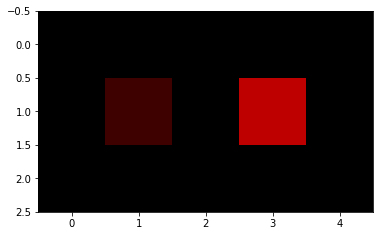

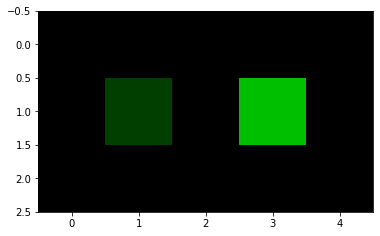

In [9]:
# Settings for domain A (red)
offset_A = 0.25
ratio_A = 0.5
color_A = 0
std_A = 0.01
dataset_A = ColorDataset(offset=offset_A, ratio=ratio_A, color=color_A, std=std_A)
dataloader_A = DataLoader(dataset_A, batch_size=256, shuffle=True)

# Settings for domain B (green)
offset_B = 0.25
ratio_B = 0.5
color_B = 1
std_B = 0.01
dataset_B = ColorDataset(offset=offset_B, ratio=ratio_B, color=color_B, std=std_B)
dataloader_B = DataLoader(dataset_B, batch_size=256, shuffle=True)

visualize_img_batch(dataset_A.example_imgs)
visualize_img_batch(dataset_B.example_imgs)

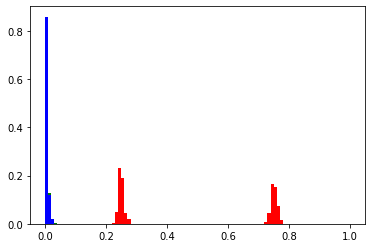

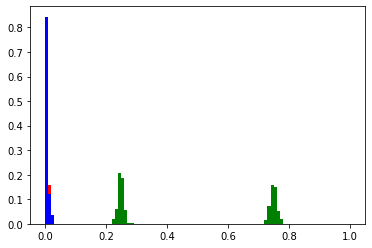

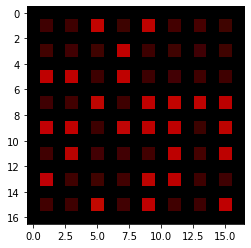

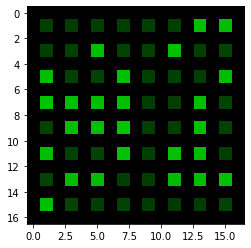

In [10]:
import cv2

def plot_hist(data):
    data = data.permute(1,0,2,3).view(3,-1).cpu()
    for i, c in enumerate(('r', 'g', 'b')):
        plt.hist(data[i], weights=torch.ones(len(data[i]))/len(data[i]), 
                 color=c, bins=100, range= (0, 1))
        x_unique_count = torch.stack([(data==x_u).sum() for x_u in data.unique()])
    plt.show()

for i, (data_A, data_B) in enumerate(zip(dataloader_A, dataloader_B)):
#     print('True ratio domain A:', dataloader_A.dataset.ratio)
    plot_hist(data_A)
#     print('True ratio domain B:', dataloader_B.dataset.ratio)
    plot_hist(data_B)
    
    visualize_img_batch(data_A[:64].cpu())
    visualize_img_batch(data_B[:64].cpu())
    break

## The training loop

In [21]:
# Initialize the networks
generator_A = Generator().cuda()
generator_B = Generator().cuda()
discriminator_A = Discriminator().cuda()
discriminator_B = Discriminator().cuda()
weight_network_A = WeightNet().cuda()
weight_network_B = WeightNet().cuda()

# Initialize the optimizers
optimizer_g = optim.Adam(itertools.chain(generator_A.parameters(),
                                         generator_B.parameters()), lr=0.002, betas=(0.5, 0.999))#, lr=0.01)
optimizer_d = optim.Adam(itertools.chain(discriminator_A.parameters(),
                                         discriminator_B.parameters()), lr=0.002, betas=(0.5, 0.999))#, lr=0.01)
optimizer_w = optim.Adam(itertools.chain(weight_network_A.parameters(), 
                                         weight_network_B.parameters()), lr=0.002, betas=(0.5, 0.999))#, lr=0.01)

# Store values
samples_A = []
samples_B = []

losses_g = []
losses_d = []
losses_w = []

Lminusses = []
Lplusses = []

example_importances_A = []
example_importances_B = []

criterion_D = nn.MSELoss()
criterion_G = nn.MSELoss()
criterion_cycle = nn.MSELoss()
criterion_L2 = nn.MSELoss()

sampled_batch_size = 64 # The amount of images sampled using importance sampling

for epoch in range(1):
    for i, (data_A, data_B) in enumerate(zip(dataloader_A, dataloader_B)):
       
        # Set gradients to zero
        optimizer_d.zero_grad()
        optimizer_g.zero_grad()
        optimizer_w.zero_grad()

        fake_A = generator_A(data_B)
        fake_B = generator_B(data_A)
        
        # The sampling process ----------------------------------------------------------------------------
        # Get the importances for each image in domain A
        importances_A = 0.5 * (
            torch.sigmoid(weight_network_A(data_A).cuda().squeeze()) + 
            torch.sigmoid(-weight_network_B(fake_B.detach()).cuda().squeeze()))
        
        # Get the importances for each image in domain B
        importances_B = 0.5 * (
            torch.sigmoid(-weight_network_A(fake_A.detach()).cuda().squeeze()) + 
            torch.sigmoid(weight_network_B(data_B).cuda().squeeze()))
        
        sampled_idx_A = list( # Sample from batch A according to these importances
            torch.utils.data.sampler.WeightedRandomSampler(importances_A, 
                                                           sampled_batch_size, 
                                                           replacement=False))

        sampled_importances_A = importances_A[sampled_idx_A] # The importances assigned to the smaller batch
        real_A = data_A[sampled_idx_A] # The sampled smaller batch A
#         fake_A = fake_A[sampled_idx_A]

        sampled_idx_B = list( # Sample from batch Baccording to these importances
            torch.utils.data.sampler.WeightedRandomSampler(importances_B,
                                                           sampled_batch_size, 
                                                           replacement=False))

        sampled_importances_B = importances_B[sampled_idx_B] # The importances assigned to the smaller batch
        real_B = data_B[sampled_idx_B] # The sampled smaller batch B
#         fake_B = fake_B[sampled_idx_B]
        # --------------------------------------------------------------------------------------------------

        # Forward
        fake_A = generator_A(real_B)
        fake_B = generator_B(real_A)
        
        rec_A = generator_A(fake_B)
        rec_B = generator_B(fake_A)
        
        pred_real_A = discriminator_A(real_A)
        pred_real_B = discriminator_B(real_B)
        
        pred_fake_A = discriminator_A(fake_A.detach())
        pred_fake_B = discriminator_B(fake_B.detach())
        
        # The loss function --------------------------------------------------------------------------------
        loss_D_real_A = criterion_D(pred_real_A, torch.ones((pred_real_A.shape)).cuda())
        loss_D_real_B = criterion_D(pred_real_B, torch.ones((pred_real_B.shape)).cuda())

        loss_D_fake_A = criterion_D(pred_fake_A, torch.zeros((pred_fake_A.shape)).cuda())
        loss_D_fake_B = criterion_D(pred_fake_B, torch.zeros((pred_fake_B.shape)).cuda())
        
        loss_D_A = (((loss_D_real_A + loss_D_fake_A) * 0.5)).cuda()
        loss_D_B = (((loss_D_real_B + loss_D_fake_B) * 0.5)).cuda()
        
        loss_G_A = (criterion_G(discriminator_A(fake_A), torch.ones((pred_fake_A.shape)).cuda()) )
        loss_G_B = (criterion_G(discriminator_B(fake_B), torch.ones((pred_fake_A.shape)).cuda()) )
        
        cycle_A = (criterion_cycle(real_A, rec_A))
        cycle_B = (criterion_cycle(real_B, rec_B))
        cycle = cycle_A + cycle_B
        
        loss_d = (loss_D_A + loss_D_B)
        loss_g = (loss_G_A + loss_G_B) + cycle

        #Loss for the weight network
        Lmin  = (loss_G_A.detach() * sampled_importances_A/sampled_importances_A.detach()).sum()
        Lplus = (loss_G_B.detach() * sampled_importances_B/sampled_importances_B.detach()).sum()

        loss_w = (Lmin + Lplus)**2
        # ---------------------------------------------------------------------------------------------------

        optimizer_g.zero_grad()
        loss_g.backward()
        optimizer_g.step()

        optimizer_d.zero_grad()
        loss_d.backward()
        optimizer_d.step()

        optimizer_w.zero_grad()
        loss_w.backward()
        optimizer_w.step()        
        
        # Store values --------------------------------------------------------------------------------------
        losses_g += [loss_g.item()]
        losses_d += [loss_d.item()]
        losses_w += [loss_w.item()]

        Lminusses += [Lmin.item()]
        Lplusses += [Lplus.item()]

        w_a = weight_network_A(dataset_A.example_imgs.cuda())
        w_b = weight_network_B(dataset_B.example_imgs.cuda())
        example_importances_A += [(w_a[0].item(), w_a[1].item())] # Store examples in a list
        example_importances_B += [(w_b[0].item(), w_b[1].item())] # Store examples in a list
        # ---------------------------------------------------------------------------------------------------

        # Print statistics
        if i % 500 == 0:
            samples_A += [fake_A.detach()]
            samples_B += [fake_B.detach()]
            print('step', i, 'loss_g', loss_g.item(), 'loss_d', loss_d.item(), 'loss_w', loss_w.item())

step 0 loss_g 1.2486512660980225 loss_d 0.5535836219787598 loss_w 2947.953369140625
step 500 loss_g 0.676954984664917 loss_d 0.4631189703941345 loss_w 1342.9429931640625
step 1000 loss_g 0.6521854400634766 loss_d 0.42488986253738403 loss_w 1476.03564453125
step 1500 loss_g 0.6135010123252869 loss_d 0.44503846764564514 loss_w 1333.955078125
step 2000 loss_g 0.5833691954612732 loss_d 0.46388572454452515 loss_w 1200.2821044921875
step 2500 loss_g 0.5685031414031982 loss_d 0.4761947989463806 loss_w 1136.113525390625
step 3000 loss_g 0.5951533317565918 loss_d 0.47067925333976746 loss_w 1150.563720703125
step 3500 loss_g 0.5983275175094604 loss_d 0.4909750819206238 loss_w 1065.4208984375
step 4000 loss_g 0.581412672996521 loss_d 0.49260205030441284 loss_w 1038.88818359375
step 4500 loss_g 0.5787774920463562 loss_d 0.5046825408935547 loss_w 985.1725463867188
step 5000 loss_g 0.5500044226646423 loss_d 0.5222659111022949 loss_w 925.325927734375
step 5500 loss_g 0.542948842048645 loss_d 0.499150

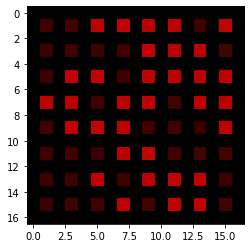

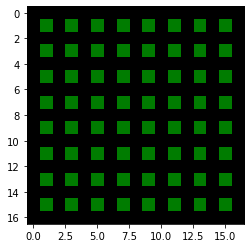

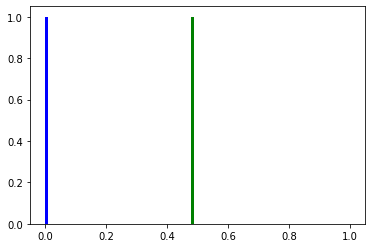

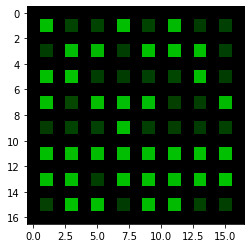

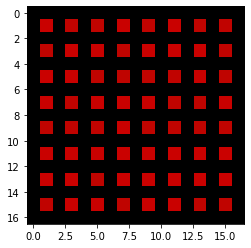

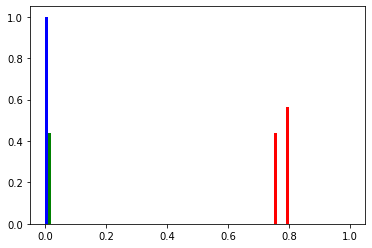

In [22]:
# Some generated images
visualize_img_batch(real_A.detach()[:64].cpu())
visualize_img_batch(fake_B.detach()[:64].cpu())
plot_hist(fake_B.detach().cpu())

visualize_img_batch(real_B.detach()[:64].cpu())
visualize_img_batch(fake_A.detach()[:64].cpu())
plot_hist(fake_A.detach().cpu())

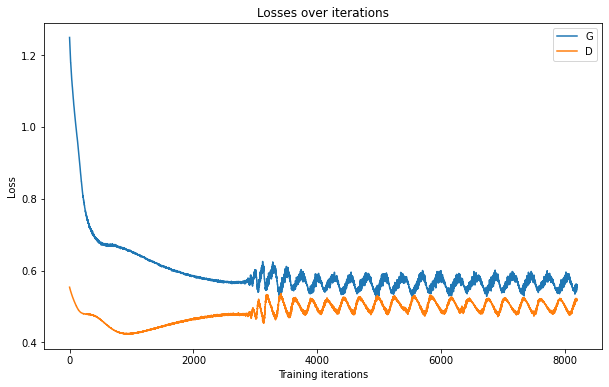

In [25]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.plot(losses_g)
plt.plot(losses_d)
plt.legend(['G', 'D'])
plt.show()

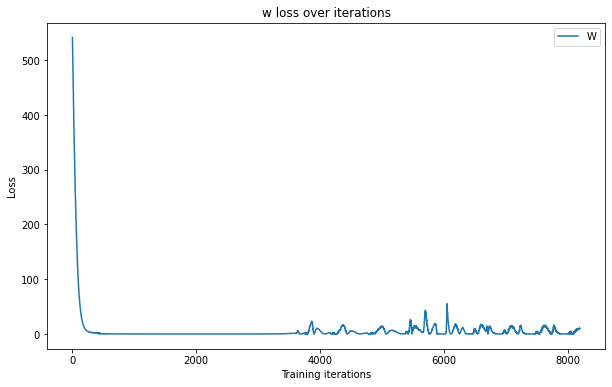

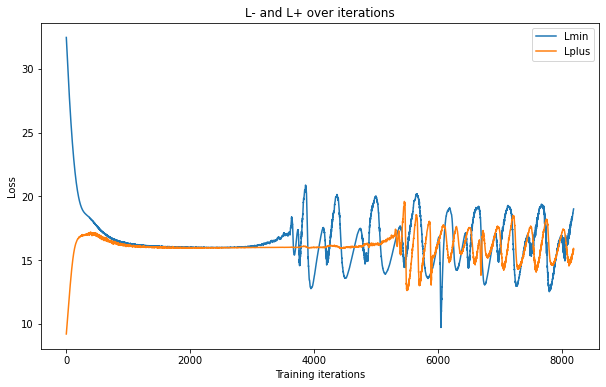

In [15]:
plt.figure(figsize=(10,6))
plt.title('w loss over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.plot(losses_w)
plt.legend(['W'])
plt.show()

plt.figure(figsize=(10,6))
plt.title('L- and L+ over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.plot(Lminusses)
plt.plot(Lplusses)
plt.legend(['Lmin', 'Lplus'])
plt.show()

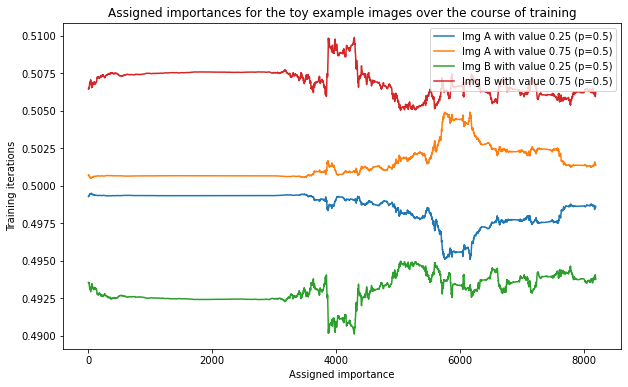

In [16]:
plt.figure(figsize=(10,6))
plt.title('Assigned importances for the toy example images over the course of training')
plt.plot(example_importances_A)
plt.plot(example_importances_B)
plt.legend(['Img A with value {} (p={})'.format(offset_A, ratio_A), 
            'Img A with value {} (p={})'.format(1-offset_A, 1-ratio_A), 
            'Img B with value {} (p={})'.format(offset_B, ratio_B), 
            'Img B with value {} (p={})'.format(1-offset_B, 1-ratio_B)])
plt.xlabel('Assigned importance')
plt.ylabel('Training iterations')
plt.show()

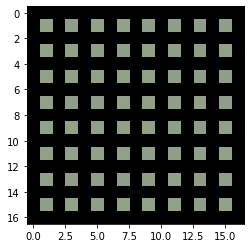

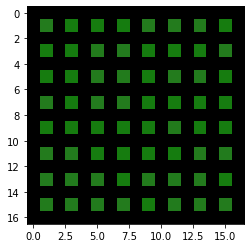

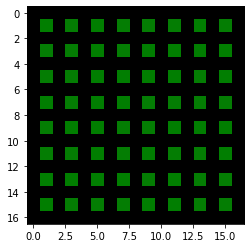

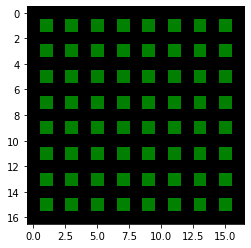

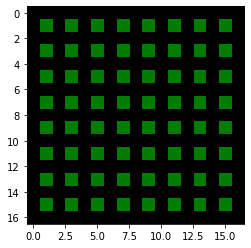

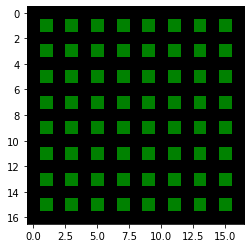

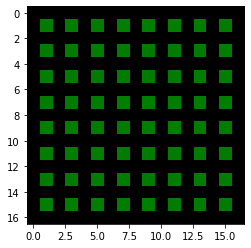

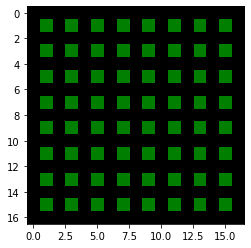

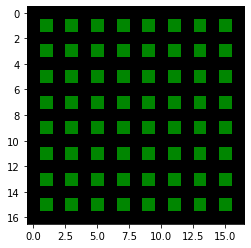

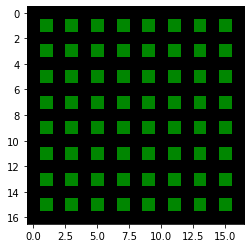

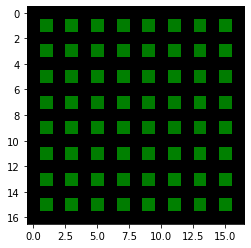

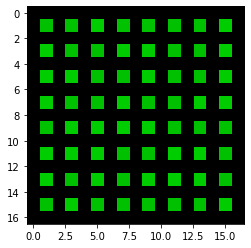

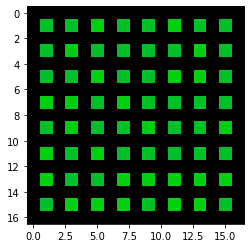

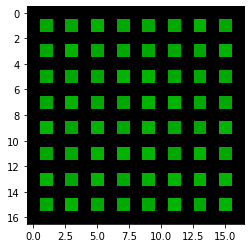

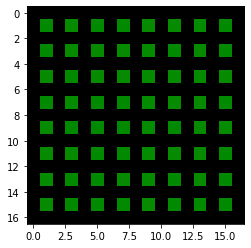

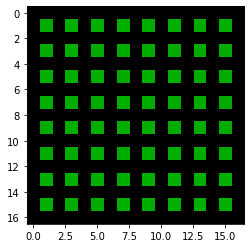

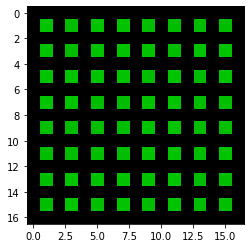

In [17]:
for img in samples_B:
    visualize_img_batch(img[:64].cpu())